In [2]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm

In [5]:
sys.path.append(r"C:\Users\Diego\Desktop\app_prod\research\TreasuryInflationPCA\root\src")
sys.path.append(r"/Users/diegoalvarez/Desktop/research/TreasuryInflationPCA/root/src")
from PCSpreadOLS import PCASpreadOLS

In [26]:
df_tsy = (PCASpreadOLS().get_tsy_fut().assign(
    security = lambda x: x.security.str.split(" ").str[0])
    [["date", "security", "PX_bps"]])

df_raw   = PCASpreadOLS().get_log_pca()
df_wider = (df_raw[
    ["date", "variable", "spread"]].
    pivot(index = "date", columns = "variable", values = "spread").
    merge(right = df_tsy, how = "inner", on = ["date"]))

In [92]:
def _get_ols(df: pd.DataFrame) -> pd.DataFrame: 

    df_tmp = df.set_index("date")
    df_out = (sm.OLS(
        endog = df_tmp.PX_bps,
        exog  = sm.add_constant(df_tmp.drop(columns = ["PX_bps"]))).
        fit().
        resid.
        to_frame(name = "resid").
        assign(lag_resid = lambda x: x.resid.shift()).
        merge(right = df, how = "inner", on = ["date"]).
        dropna())

    return df_out

df_rtn = (df_wider.groupby(
    "security").
    apply(_get_ols, include_groups = False).
    reset_index().
    drop(columns = ["level_1"]).
    assign(signal_rtn = lambda x: - np.sign(x.lag_resid) * x.PX_bps))

<Axes: xlabel='date'>

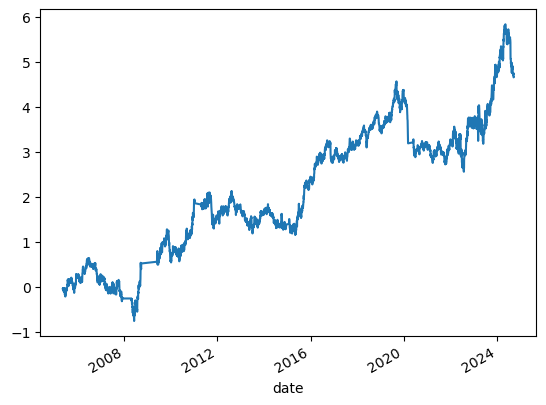

In [94]:
(df_rtn[
    ["date", "security", "signal_rtn"]].
    pivot(index = "date", columns = "security", values = "signal_rtn").
    mean(axis = 1).
    cumsum().
    plot())